In [285]:
import pandas as pd
import matplotlib.pyplot as plt
import regex
from collections import Counter
from wordcloud import WordCloud
from typing import Dict, Tuple, Sequence, Final

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans

stop_eng = set(stopwords.words('english'))

# downloads for nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

## tags options for wordnet lemmatizer tag params
TAGS_DICT: Final[Dict['str', 'str']] = {"j": wordnet.ADJ,
            "n": wordnet.NOUN,
            "v": wordnet.VERB,
            "r": wordnet.ADV
          }

[nltk_data] Downloading package punkt to /Users/lesiyonr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lesiyonr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lesiyonr/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lesiyonr/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [286]:
youtube_data_keys = {'official', 'video', 'music', 'skiza',
                     'call', 'lyrics', '𝐅𝐎𝐑', '𝐁𝐎𝐎𝐊𝐈𝐍𝐆𝐒',  '𝐂𝐀𝐋𝐋', '𝐉𝐀𝐇𝐀𝐙𝐈', 'instagram', 'twitter', 'facebook', 'channel', 'subscribe', 'youtube', 'follow', 'like', 'yuh', '𝐓𝐀𝐀𝐑𝐀𝐁', '𝐌𝐎𝐃𝐄𝐑𝐍', 'yuh', 'you', 'officiel'}
                     
stop_eng.update(youtube_data_keys)

# lambdas functions: 

classify_views = lambda x: 'Above one million' if x > 1000000 else 'Below one million'
classify_likes = lambda x: 'Above 20k' if x > 20000 else 'Below 20k'
classify_comments = lambda x: 'Above 1k' if x > 1000 else 'Below 1k'

#Vectorization

def get_wordnet_tag_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].lower()
  return TAGS_DICT.get(tag[0], 'n')

def lemmatize_word(token):
  wordnet_lemmatizer = WordNetLemmatizer()
  pos = get_wordnet_tag_pos(token)
  return wordnet_lemmatizer.lemmatize(token, pos = pos)

def tokenize_words(data, method_type=''):
  tokenized_data = []
  
  for title in data:

    tokenize = [str(word.strip(":,.!?“”-(){}[]").lower()) for word in title.split()]

    filtered_token = list(filter(
        lambda word: not (
            word in stop_eng or len(word) <= 3 or word.isnumeric() or word.startswith('#') or word.startswith('+') or word.startswith('@')), tokenize))

    lemmatized_tokens = [lemmatize_word(token) for token in filtered_token]

    if method_type == 'document filter':
      tokenized_data.append(' '.join(lemmatized_tokens))
    else:
      tokenized_data.extend(lemmatized_tokens)
      
  return tokenized_data

In [287]:
youtube_data = pd.read_csv('feed_history.csv').drop(columns=['Unnamed: 0'])

category = {
    1: 'Film & Animation',
    2: 'Autos & Vehicles',
    10: 'Music',
    15: 'Pets & Animals',
    17: 'Sports',
    19: 'Travel & Events',
    20: 'Gaming',
    22: 'People & Blogs',
    23: 'Comedy',
    24: 'Entertainment',
    25: 'News & Politics',
    26: 'Howto & Style',
    27: 'Education',
    28: 'Science & Technology'
}
youtube_data['category_id'] = youtube_data['category_id'].apply(
    lambda x: category[x])


In [288]:
youtube_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             158 non-null    object
 1   category_id    158 non-null    object
 2   channel_title  158 non-null    object
 3   channel_id     158 non-null    object
 4   description    143 non-null    object
 5   published_at   158 non-null    object
 6   title          158 non-null    object
 7   views_count    158 non-null    int64 
 8   comment_count  158 non-null    int64 
 9   likes_count    158 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 12.5+ KB


In [248]:
youtube_data.describe()

,views_count,comment_count,likes_count
count,1.580000e+02,158.000000,1.580000e+02
mean,1.526866e+07,3542.727848,1.131254e+05
std,4.998207e+07,11728.384106,4.268906e+05
min,4.500000e+01,0.000000,0.000000e+00
25%,2.813750e+04,48.500000,5.205000e+02
50%,3.983845e+05,267.000000,4.708500e+03
75%,8.373017e+06,2796.000000,4.859775e+04
max,4.492054e+08,101310.000000,3.471049e+06


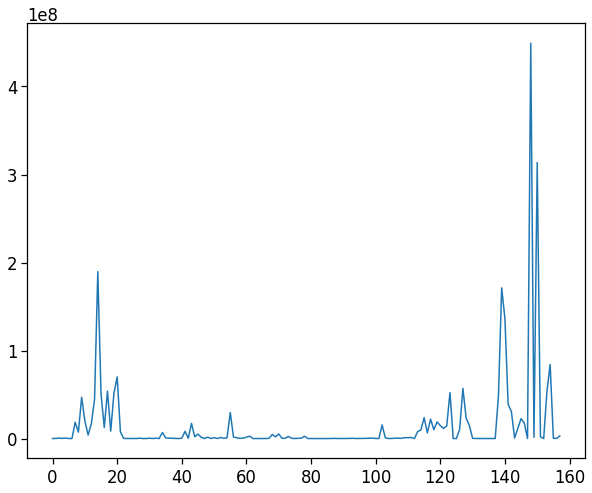

In [242]:
plt.plot(youtube_data.views_count)

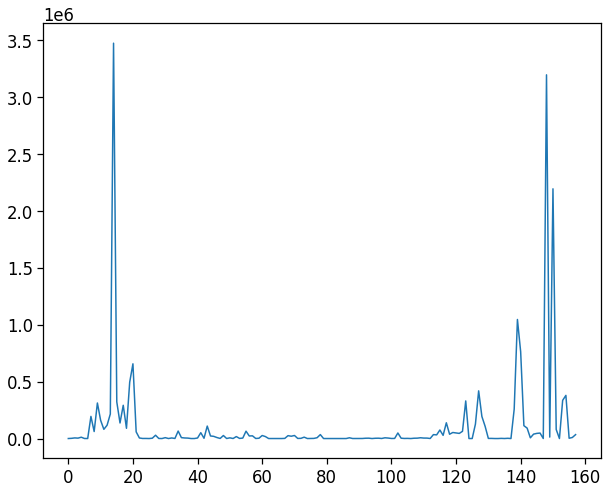

In [243]:
plt.plot(youtube_data.likes_count)

In [249]:
views_c = youtube_data['views_count'].apply(classify_views)
likes_c = youtube_data['likes_count'].apply(classify_likes)
comments_c = youtube_data['comment_count'].apply(classify_comments)
classified = pd.concat([youtube_data.loc[:, ["channel_title", "category_id"]], likes_c, views_c, comments_c], axis=1)
classified.head()

,channel_title,category_id,likes_count,views_count,comment_count
0,PeriscopeFilm,Education,Below 20k,Below one million,Below 1k
1,Unpacked,Education,Below 20k,Below one million,Above 1k
2,DW Documentary,Education,Below 20k,Below one million,Below 1k
3,Thee Pluto Show,Entertainment,Below 20k,Below one million,Above 1k
4,The Vibe Guide,Entertainment,Below 20k,Below one million,Below 1k


Text(0.5, 0.98, 'Youtube Trending Analysis')

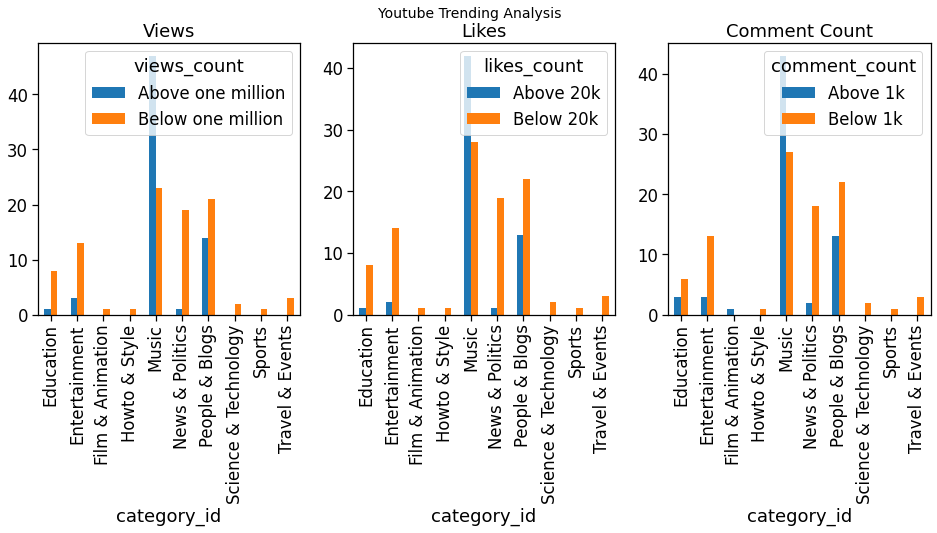

In [250]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

classified.groupby(["category_id", "views_count"]).size(
  ).unstack().plot.bar(title="Views", ax=ax[0])
classified.groupby(["category_id", "likes_count"]).size(
  ).unstack().plot.bar(title="Likes", ax=ax[1])
classified.groupby(["category_id", "comment_count"]).size( 
  ).unstack().plot.bar(title="Comment Count", ax=ax[2])
fig.suptitle("Youtube Trending Analysis", fontsize=14)

<AxesSubplot:title={'center':'Category Summary Analysis'}, xlabel='category_id'>

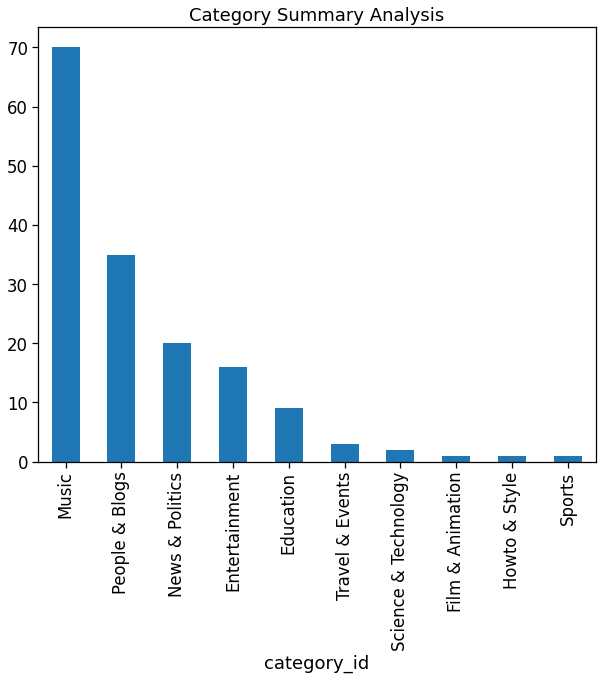

In [251]:
youtube_data.groupby("category_id").size().sort_values(ascending=False).plot.bar(title = 'Category Summary Analysis')

Text(0.5, 1.0, 'Title Frequency Analysis')

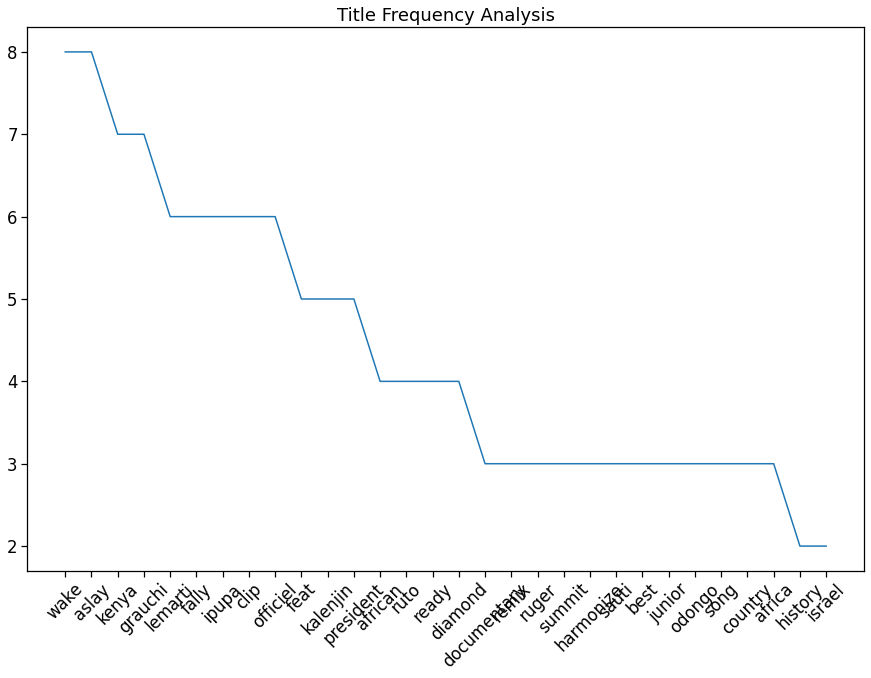

In [252]:
# Visualizing the most common trends using dictionary word counters for text representation

# Unigram Model

## Unigram model makes a dictionary of 1 element and counts it occurences. The vocabulary becomes the features which are used to make the vectors for each sentences. 

title_counter = Counter(tokenize_words(youtube_data.title))
title_counter_sorted = dict(sorted(title_counter.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(15, 10))
plt.plot(list(title_counter_sorted.keys())[
         :30], list(title_counter_sorted.values())[:30])
plt.xticks(rotation=45)
plt.title('Title Frequency Analysis')

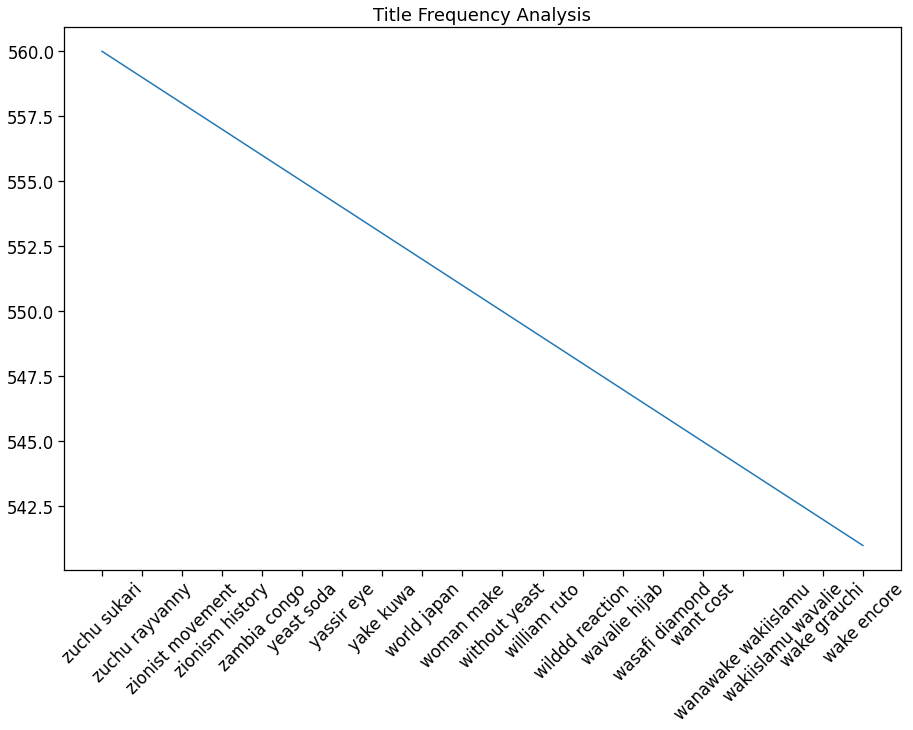

In [268]:
# N-gram model: 

# This model uses the occurence of two words and uses them as the new features for representing the document. The document are represented binarily. If the feature is present in the document, it is assigned 1 else 0. 

cv = CountVectorizer(ngram_range=[2, 2], stop_words=stop_eng)
bow = cv.fit_transform(tokenize_words(
    youtube_data.title, method_type='document filter')).toarray()

title_counter_sorted = dict(
    sorted(cv.vocabulary_.items(), key=lambda x: x[1], reverse=True))
    
title_counter_sorted = dict(
    sorted(cv.vocabulary_.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(15, 10))
plt.plot(list(title_counter_sorted.keys())[
         :20], list(title_counter_sorted.values())[:20]);
plt.xticks(rotation=45);
plt.title('Title Frequency Analysis');

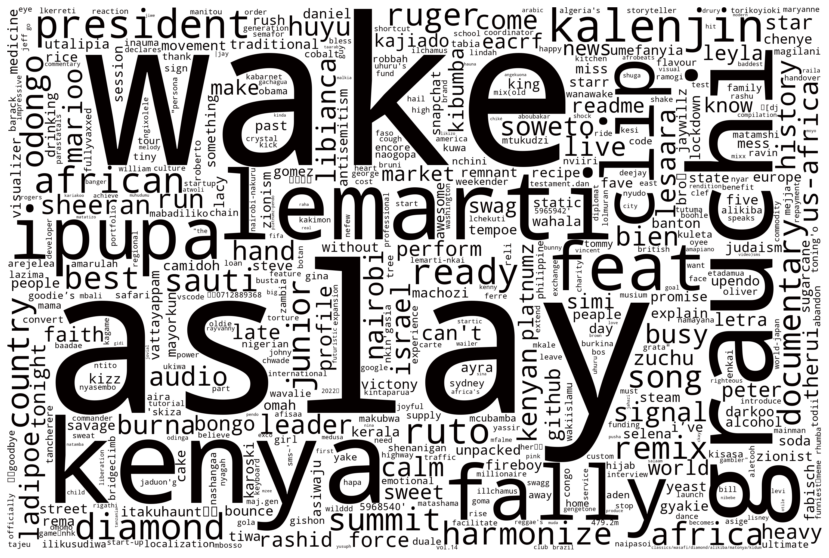

In [270]:
# word cloud visualization
title_counter = Counter(tokenize_words(youtube_data.title))
title_counter_sorted = dict(
    sorted(title_counter.items(), key=lambda x: x[1], reverse=True))
    
# change the value to black
def black_color_func(word, font_size, position, orientation, random_state=1, **kwargs):
    return ("hsl(0, 100%,1%)")

# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000

wordcloud = WordCloud(background_color="white",
                      width=3000, height=2000, max_words=500).generate_from_frequencies(title_counter_sorted)
                      
# set the word color to black
wordcloud.recolor(color_func=black_color_func)
# set the figsize
plt.figure(figsize=[15, 10])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")

(-0.5, 2999.5, 1999.5, -0.5)

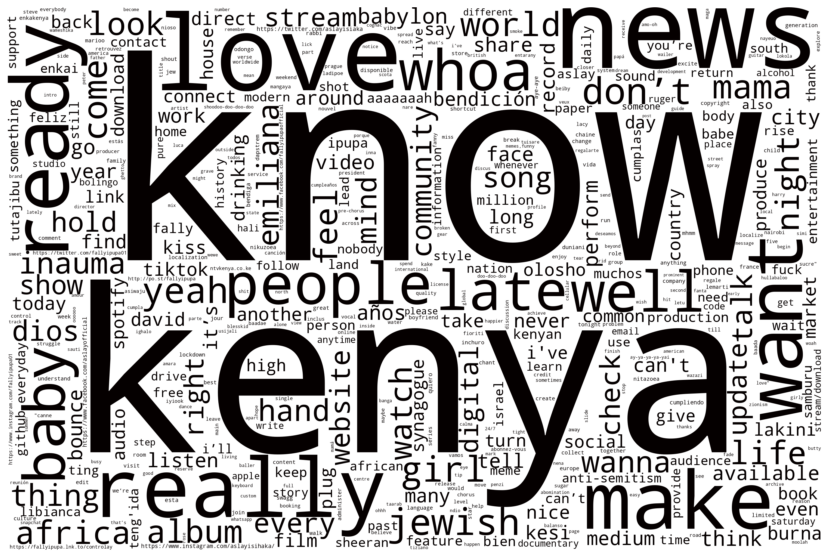

In [290]:
# word cloud visualization
title_counter = Counter(tokenize_words(youtube_data.description.dropna()))
title_counter_sorted = dict(
    sorted(title_counter.items(), key=lambda x: x[1], reverse=True))

# change the value to black

def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return ("hsl(0, 100%,1%)")

# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000

wordcloud = WordCloud(background_color="white",
                      width=3000, height=2000, max_words=500).generate_from_frequencies(title_counter_sorted)

# set the word color to black
wordcloud.recolor(color_func=black_color_func)
# set the figsize
plt.figure(figsize=[15, 10])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")

In [62]:
# TF-IDF (Term Frequency and Inverse Document Frequency)

# Term-Frequency: the number of occurence (Term T) appearing in the document divided by the all documents. 
# Inverse Document Frequency: Numbers of documents in a corpus divided by the number of documents with the term T. If we have a word that comes in all documents then the resultant output of the log is zero. 

tfidf = TfidfVectorizer()
len(tfidf.fit_transform(df['text']).toarray())
print(tfidf.idf_)
print(tfidf.get_feature_names_out())
print(len(tfidf.get_feature_names()))

[1.28768207 1.69314718 1.69314718 1.28768207 1.69314718 1.28768207
 1.69314718 1.         1.28768207]
['analytics' 'and' 'appreciates' 'author' 'comment' 'on' 'reads' 'vidhya'
 'writes']
9


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [275]:
## Clustering with TFIDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(youtube_data.description.dropna())
true_k = 20
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=20, n_init=1)

## References: 

1. https://towardsdatascience.com/how-to-make-word-clouds-in-python-that-dont-suck-86518cdcb61f